# 팀 스마일C 코드 제출
* 팀원: 정우섭, 김유민, 김유진, 장동언, 황정묵
* PRIVATE SCORE: 0.65887 
* PRIVATE RANKING: 36

# 0.Data Load

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install optuna 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 20.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, cross_validate


import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler
from optuna import Trial

from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

# sequential model modeling 
import tensorflow as tf
from tensorflow import keras 
from keras import backend as K 
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization, Conv2D, Flatten  
from keras import optimizers, metrics, callbacks
from tensorflow.keras.backend import clear_session

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정
seed_num=37

from google.colab import drive # GoogleDrive mount
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [ ]:
# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 


In [ ]:
# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)


In [ ]:
# 3) MinMaxscaling: only `X_???` values (continuous)
from sklearn.preprocessing import StandardScaler
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,
                                                  test_size=0.3,random_state=seed_num)

In [ ]:
# histogram imbalance distribution --> MinMaxscaling 


## 1.1 EDA

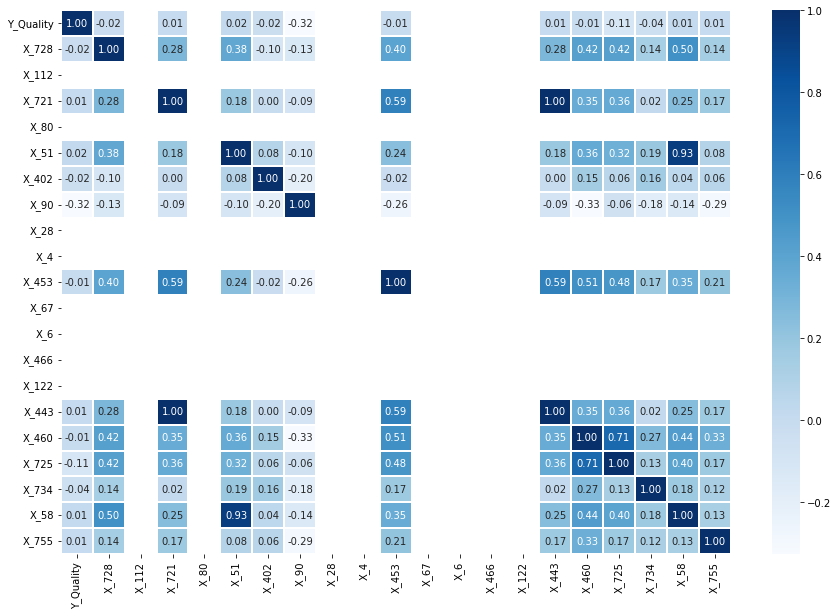

In [ ]:
# random 20 features list (모두 NaN인 컬럼 제외하고, 랜덤 20개 feature의 상관관계 히트맵)
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

import random
a = ['Y_Quality']
for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

# heatmap: `random X features` and `Y_Quality` correlation 
corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

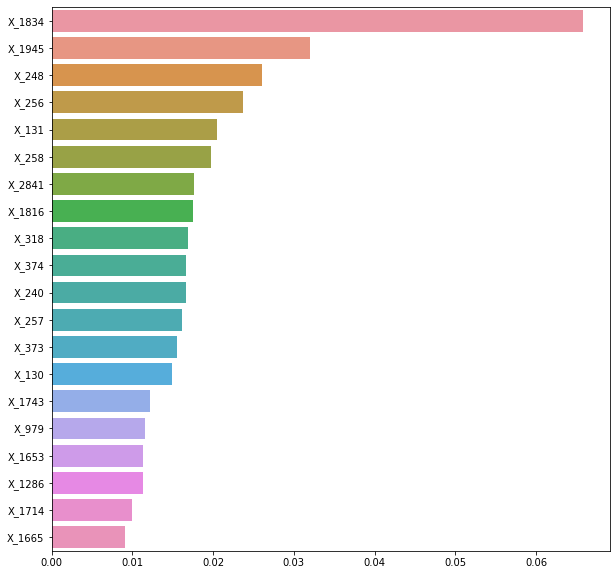

In [ ]:
# feature 중요도 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
rf_run = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
rf_run.fit(X_train, y_train)  
ftr_importances_values = rf_run.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

Done.


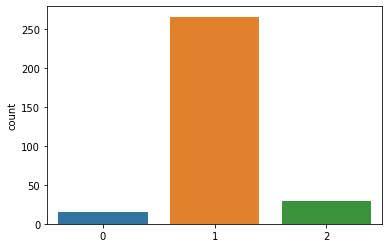

In [ ]:
x=train_x.loc[:,['X_1834','X_1945','X_256','X_248','X_258','X_373','X_131','X_2841']]
y=train_y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as ms

model = GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')
y_pred = model.predict(X_test)
# test_x = test_x.drop(columns=['LINE', 'PRODUCT_CODE'])

test_x=test_x.loc[:,['X_1834','X_1945','X_256','X_248','X_258','X_373','X_131','X_2841']]
preds = model.predict(test_x)
sns.countplot(x=preds); 
# preds.value_counts()

In [ ]:
train_x.describe()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,598.000000,598.000000,598.0,598.000000,598.000000,598.0,598.000000,598.000000,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.0,598.0
mean,3.214047,1.157191,1.406355,0.544265,0.0,0.583612,0.551383,0.0,0.459381,0.533141,...,0.141039,0.130564,0.137318,0.144148,0.139755,0.165552,0.0,0.0,0.0,0.0
std,1.703579,0.983298,4.655332,0.461135,0.0,0.493372,0.467361,0.0,0.392067,0.450953,...,0.318552,0.295577,0.310467,0.327595,0.312991,0.371989,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,2.000000,2.000000,0.892157,0.0,1.000000,0.909091,0.0,0.725806,0.909091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,5.000000,2.000000,2.000000,0.931373,0.0,1.000000,0.909091,0.0,0.806452,0.909091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,5.000000,2.000000,103.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0


# 2.Modeling

## 2.1 ML models

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    RandomForestClassifier(random_state=seed_num), 
    GradientBoostingClassifier(random_state=seed_num),   # GBC: no tuning is the best 
    XGBClassifier(random_state=seed_num),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    RidgeClassifierCV(),  # RidgeClassifier: no seed setting argument  
    BaggingClassifier(random_state=seed_num)]

models

[RandomForestClassifier(random_state=37),
 GradientBoostingClassifier(random_state=37),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=37, ...),
 LGBMClassifier(objective='multiclass', random_state=37),
 RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
 BaggingClassifier(random_state=37)]

In [ ]:
# find weights for each model 
model_list = ['RF', 'GBC', 'XGB', 'LGBM', 'Catboost', 'Ridge', 'Bagging']
i=0

for model in models: 
        
    if i == 4: 
        preds = model.fit(X_train, y_train).predict(X_test)
        preds = preds.reshape(1,180)
        preds = list(preds[0])
    else: 
        preds = model.fit(X_train, y_train).predict(X_test)

    globals()[f'preds_{model_list[i]}'] = preds   # set variable name for each model prediction results  
  
    score = sklearn.metrics.accuracy_score(y_test, preds)
    i += 1
    print(f'{model} accuracy: \n', score)
#   print(model,  globals()[f'preds_{model_list[i]}'])   shell script???????? .sh     


RandomForestClassifier(random_state=37) accuracy: 
 0.7888888888888889
GradientBoostingClassifier(random_state=37) accuracy: 
 0.8
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) accuracy: 
 0.7722222222222223
LGBMClassifier(objective='multiclass', random_state=37) accuracy: 
 0.7888888

## 2.2 sequential MLP 
* torch code can make the same result --> TRY!!! 

In [ ]:
model = Sequential([
    # Input layer: ReLU (decide input size according to dimension)
    Dense(2056, 
          activation='relu', input_shape=(train_x.shape[-1],)),    
    # BatchNormalization(), 
    Dropout(0.3), 




    # Output layer: softmax 
    Dense(3, activation='softmax')  
    ])
# model.save('sequential')
# CUDA   torch code ㅠㅠㅠㅠ 
model.summary()
model.compile(optimizer = optimizers.Adam(1e-3),  # default learning rate=1e-3 
            loss='sparse_categorical_crossentropy',  # tow or more label classes (`Y_Class`: 0,1,2)
            metrics=['accuracy'])

history = model.fit(train_x, train_y, 
                    epochs=5,
                    batch_size=256,  # batch size: 2^x && half of data size(598/2) 
                    validation_split=0.2,
                    )   

preds = model.predict(test_x) 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               1473536   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 1,475,075
Trainable params: 1,475,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
6/6 [==============================] - 1s 45ms/step - loss: 1.8346 - accuracy: 0.5858 - val_loss: 1.9028 - val_accuracy: 0.6250
Epoch 2/5
6/6 [==============================] - 0s 10ms/step - loss: 1.1745 - accuracy: 0.6632 - val_loss: 1.3163 - val_accuracy: 0.6167
Epoch 3/5
6/6 [=================

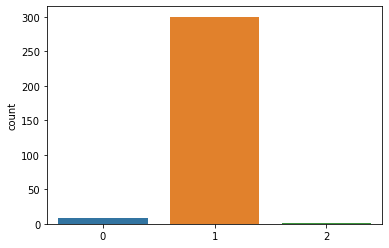

In [ ]:
a=[]

for i in preds: 
    i = list(i)
    a.append(i.index(max(i)))

sns.countplot(x=a);    

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = a

submit.to_csv('LReluDO3b80ep5LR1e3-ANN-smartFactorySubmission.csv', index=False)

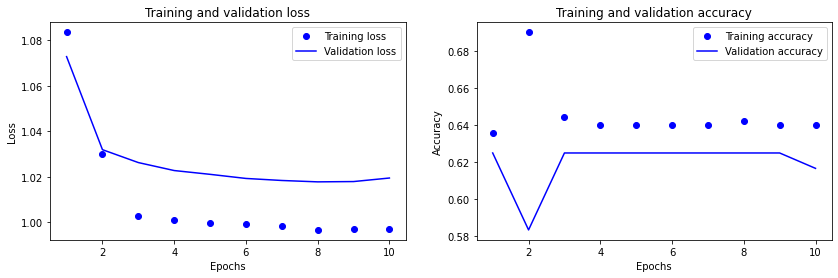

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(1,2,figsize=(14,4))
ax= axes.flatten()
a, b = ax[0], ax[1]

a.plot(epochs, history.history["loss"], "bo", label="Training loss")
a.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
a.set_title("Training and validation loss")
a.set_xlabel("Epochs")
a.set_ylabel("Loss")
a.legend()   

b.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
b.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
b.set_title("Training and validation accuracy")
b.set_xlabel("Epochs")
b.set_ylabel("Accuracy")
b.legend();

# 3.Params Optimization
1. GridSearch 
2. Optuna
3. RandomizedSearchCV

## 3.1 GBC

In [ ]:
gb_class = GradientBoostingClassifier(random_state = 37) 

kf = KFold(n_splits=5, shuffle=True, random_state=37)
# kf = sklearn.model_selection.StratifiedKFoldKFold(n_splits=5, shuffle=True, random_state=37)

# stratified --> too many Class 0, Class 2 over-predicted 
# non-stratified --> training score 77.0 

scores = cross_validate(gb_class, X_train, y_train, 
                        cv = kf, scoring = "accuracy", 
                        return_train_score = True, n_jobs = -1) 

In [ ]:
print(scores) 
scoring = scores['test_score'].mean()
print(f'Best Accuracy: {round(scoring, 2)*100}')  

{'fit_time': array([41.62663841, 41.74060178, 37.6939764 , 37.52241993, 24.01014924]), 'score_time': array([0.03269506, 0.03415394, 0.03555298, 0.0340457 , 0.0192306 ]), 'test_score': array([0.78333333, 0.79166667, 0.775     , 0.78991597, 0.73109244]), 'train_score': array([1.        , 0.9958159 , 1.        , 1.        , 0.99791232])}
Best Accuracy: 77.0


In [ ]:
def objective(trial, X, y, cv, scoring):
  """
  An objective function to tune hyperparameters of Gradient Boosting Classifier.
  Args:
    trial: an Optuna trial
    X: DataFrame object, features
    y: Series object, Labels
    cv: k folds to cross-validate
    scoring: String, evaluation metric
  Return:
    Mean test accuracy
  """

  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    "random_state": 42,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy

In [ ]:
study = optuna.create_study(direction = "maximize")

kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

func = lambda trial: objective(trial, X_train, y_train, 
                               cv = kf, scoring = "accuracy")

# %%time
# Start optimizing with 100 trials
study.optimize(func, n_trials = 10)

print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")    

[I 2023-02-23 23:40:00,843] A new study created in memory with name: no-name-ed8b6a39-0289-437f-844d-22d3bdfaf955
[I 2023-02-23 23:43:04,778] Trial 0 finished with value: 0.7608263305322129 and parameters: {'n_estimators': 4700, 'learning_rate': 0.0005668195633865373, 'max_depth': 6, 'subsample': 0.9, 'max_features': 'log2'}. Best is trial 0 with value: 0.7608263305322129.
[I 2023-02-23 23:48:01,267] Trial 1 finished with value: 0.8026050420168067 and parameters: {'n_estimators': 200, 'learning_rate': 0.21851112508358236, 'max_depth': 6, 'subsample': 0.7, 'max_features': 'auto'}. Best is trial 1 with value: 0.8026050420168067.
[I 2023-02-23 23:49:11,431] Trial 2 finished with value: 0.79593837535014 and parameters: {'n_estimators': 3400, 'learning_rate': 0.09944316159185719, 'max_depth': 9, 'subsample': 0.9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8026050420168067.
[I 2023-02-23 23:50:10,982] Trial 3 finished with value: 0.7925630252100839 and parameters: {'n_estimators'

KeyboardInterrupt: ignored

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

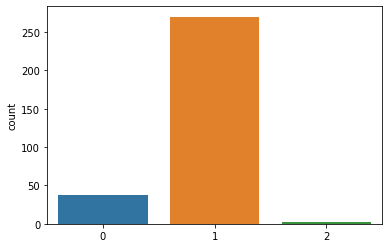

In [ ]:
import imblearn

# Trial 8 finished with value: 0.7976750700280112 and 
# param = {'n_estimators': 2500, 'learning_rate': 0.24437231062646464, 'max_depth': 7, 'subsample': 0.9, 'max_features': 'sqrt'}

# value: 0.7926050420168067 
param= {'n_estimators': 1400, 'learning_rate': 0.007793231258605556, 'max_depth': 6, 'subsample': 0.8, 'max_features': 'sqrt'}

GBC =  GradientBoostingClassifier(random_state=37, **param,                              
                                  ).fit(train_x, train_y)
preds = GBC.predict(test_x)
sns.countplot(x=preds);
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

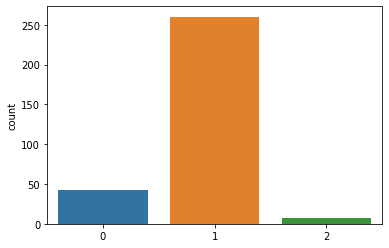

In [ ]:
# Best is trial 0 with value: 0.8026750700280111.
params= {'n_estimators': 4700, 'learning_rate': 0.007080906403563565, 'max_depth': 4, 'subsample': 0.8, 'max_features': 'sqrt'}

GBC =  GradientBoostingClassifier(random_state=37,
                                  **params,                              
                                  ).fit(train_x, train_y)
preds = GBC.predict(test_x)
sns.countplot(x=preds);
preds

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('GBCoptuna-smartFactorySubmission.csv', index=False)

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     
# hyper-parameter tuning with OPTUNA  
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=37)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)  

In [ ]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, 'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', 'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, 'od_type': 'IncToDec', 'od_wait': 42}
a = CatBoostClassifier(**params, verbose=False, random_state=37)
a.fit(X_train, y_train)


In [ ]:
# [I 2023-02-23 17:18:12,087] A new study created in memory with name: no-name-1c47b3dc-1271-4545-be27-7bdc29c83e1d
# [I 2023-02-23 17:19:24,357] Trial 0 finished with value: 0.9402040816326529 and parameters: {'n_estimators': 1900, 'learning_rate': 0.00848473740560785, 'max_depth': 6, 'subsample': 0.5, 'max_features': 'log2'}. Best is trial 0 with value: 0.9402040816326529.
# [I 2023-02-23 17:20:55,754] Trial 1 finished with value: 0.9483907661425226 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04356159311638129, 'max_depth': 6, 'subsample': 0.8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9483907661425226.
# [I 2023-02-23 17:22:07,237] Trial 2 finished with value: 0.9246403479424556 and parameters: {'n_estimators': 700, 'learning_rate': 0.0028581111146054757, 'max_depth': 8, 'subsample': 0.5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9483907661425226.
# The highest accuracy reached by this study: 94.83907661425226%.
# Best params:
# 	n_estimators: 1000
# 	learning_rate: 0.04356159311638129
# 	max_depth: 6
# 	subsample: 0.8
# 	max_features: sqrt


# 'n_estimators': 500, 'learning_rate': 0.23063625169737476, 'max_depth': 9, 
# 'subsample': 0.6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9508464369354298

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
import pickle
pickle.dump(model, open("catboost_model.pkl", "wb"))
     

optuna.visualization.plot_optimization_history(study)
     

optuna.visualization.plot_parallel_coordinate(study)
     

# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "iterations",
        "learning_rate",
        "depth",
        "l2_leaf_reg",
        "bootstrap_type",
        "random_strength",
        "bagging_temperature",
        "od_type",
        "od_wait"
        ],
)

[W 2023-02-25 16:04:26,811] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,813] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,815] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,816] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,817] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,819] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,820] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,821] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,822] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,824] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,826] Param bootstrap_type unique value length is less than 2.
[W 2023-02-25 16:04:26,827] Param bootstrap_type unique value len

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier(n_estimators= 200, 
                                       learning_rate=0.21851112508358236, 
									max_depth= 6,
									subsample= 0.7, 
									max_features= 'auto').fit(X_train, y_train) 

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# GBC_model = GradientBoostingClassifier(random_state=37,
#                                     n_estimators= 3700,
# 	learning_rate= 0.03084747392010545,
# 	max_depth= 6,
# 	subsample= 0.8,
# 	max_features= 'auto').fit(X_train, y_train) 

Done.


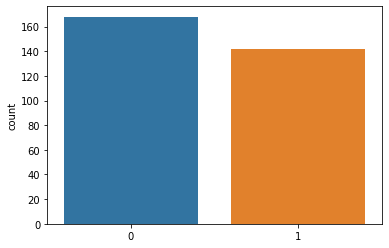

In [ ]:
# preds = GBC_model.predict(X_test)
# print(f1_score(y_test, preds, avg='macro'))

preds = GBC_model.predict(test_x)
print('Done.')
sns.countplot(x=preds);

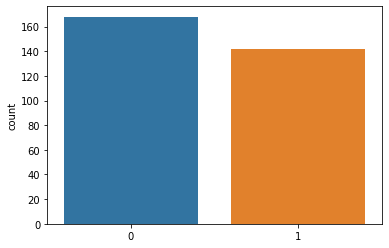

In [ ]:
sns.countplot(x=preds);

## 3.3 MLP

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [0 if label == 0 else 1 for label in df['HeartDisease']]
        self.features = df.drop(columns=['HeartDisease'], axis=1).values.tolist()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_features(self, idx):
        return np.array(self.features[idx])

    def __getitem__(self, idx):
        batch_features = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_features, batch_y

In [ ]:
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
    model = build_model(params)
    
    accuracy = train_and_evaluate(params, model)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2023-02-26 13:16:04,739] A new study created in memory with name: no-name-18123d27-0eb4-4209-9d15-b9575511aa52


In [ ]:
def build_model(params):
    
    in_features = train_x.shape[-1]
    
    return nn.Sequential(
    
        nn.Linear(in_features, params['n_unit']),
        nn.LeakyReLU(),

        nn.Linear(params['n_unit'], 2),
        nn.LeakyReLU()
        
    )
 

In [ ]:

# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(param, model):
    
    df = pd.read_csv('heart.csv')
    df = pd.get_dummies(df)
    
    train_data, val_data = train_test_split(df, test_size = 0.2, random_state = 42)
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_dataloader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(val_data)

    return accuracy
  
 # Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
     model = build_model(params)
    
     accuracy = train_and_evaluate(params, model)

     return accuracy

# 4.Ensemble

## 3.1 VotingClassifier
1. Cross-Validation 구축 후 성능 비교

In [ ]:
#GBC_param= {'n_estimators': 1400, 'learning_rate': 0.007793231258605556, 'max_depth': 6, 'subsample': 0.8, 'max_features': 'sqrt'}
CB_param= {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, 'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', 'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, 'od_type': 'IncToDec', 'od_wait': 42}

models = [
    CatBoostClassifier(
        # objective='MultiClass', task_type='GPU', one_hot_max_size=2, iterations=4000, learning_rate=0.05, 
        verbose=False, random_seed=seed_num, 
        **CB_param
                                   ),
    # LGBMClassifier(objective='multiclass', random_state=seed_num),
    XGBClassifier(random_state=seed_num),
    GradientBoostingClassifier(random_state=seed_num),    
    # RidgeClassifierCV(),
]
[x.fit(train_x, train_y) for x in models]


 XGBClassifier(objective='multi:softprob', random_state=37),
 GradientBoostingClassifier(random_state=37)]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

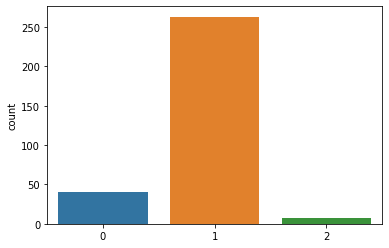

In [ ]:
def predict(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = predict(models, test_x, 'hard',  
                [2,1,2] )

sns.countplot(x=preds);    
preds


1    263
0     40
2      7
Name: Y_Class, dtype: int64

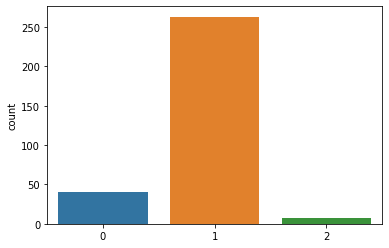

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CparamXG212-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);
submit.Y_Class.value_counts()

1    265
0     37
2      8
Name: Y_Class, dtype: int64

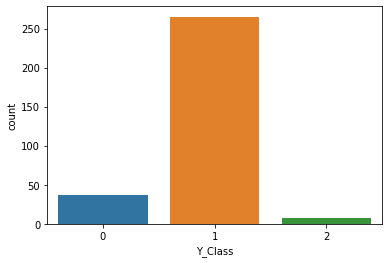

In [ ]:
aaa = pd.read_csv('CXG212(1)-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

In [ ]:
# 148  1 2 
# 163  2
# 166  2 
# 295  1 0 
36/495 

0.07272727272727272

1    253
0     42
2     15
Name: Y_Class, dtype: int64

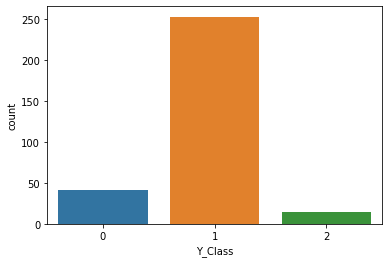

In [ ]:
aaa = pd.read_csv('/content/drive/MyDrive/GBCminmax-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    260
0     43
2      7
Name: Y_Class, dtype: int64

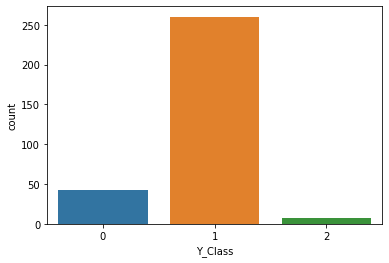

In [ ]:
aaa = pd.read_csv('/content/drive/MyDrive/GBCoptuna-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    267
0     37
2      6
Name: Y_Class, dtype: int64

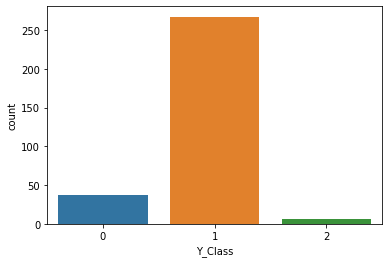

In [ ]:
aaa = pd.read_csv('/content/drive/MyDrive/voting.catB_GBC-smartFactorySubmission.csv')
sns.countplot(x=aaa.Y_Class);
aaa.Y_Class.value_counts()

1    274
0     29
2      7
Name: Y_Class, dtype: int64

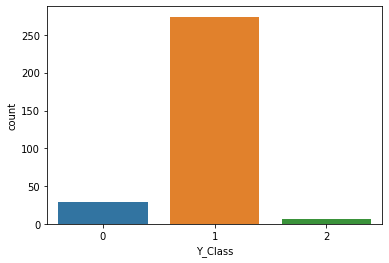

In [ ]:
sdf = pd.read_csv('/content/drive/MyDrive/smartFactory_submission18.csv')
sns.countplot(x=sdf.Y_Class);
sdf.Y_Class.value_counts()

## 3.2 StackingClassifier

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

models = [
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    XGBClassifier(random_state=seed_num),
    GradientBoostingClassifier(random_state=seed_num),   # GBC: no tuning is the best 
    RidgeClassifierCV(),
]

# [x.fit(train_x, train_y) for x in models]   

In [ ]:
# find weights for each model 
model_list = ['catboost', 'lgbm', 'xgb', 'gradient', 'ridge']
num=0

for model in models: 
  preds = model.fit(train_x, train_y).predict(test_x)
  if num == 0:  # catboostclassifier 
    preds= preds.reshape(1,test_x.shape[0])  # test_x.shape[0] = number of columns 
    preds = list(preds[0])
    num+=1
  else: 
    preds.reshape(1,test_x.shape[0])
    preds=list(preds)
  
  globals()[f'preds_{model_list[num]}'] = preds   # set variable name for each model prediction results  
  
  print(model,  globals()[f'preds_{model_list[num]}'])   

<catboost.core.CatBoostClassifier object at 0x7f17b43af610> [1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
LGBMClass

In [ ]:
preds_catb = [1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_lgbm = [1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_xgb = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds_bagging = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1]
preds_gradient = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
preds_ridge = [1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CXG212-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);

NameError: ignored

In [ ]:
stack = StackingClassifier(
    estimators=models,
    final_estimator=LogisticRegression(),  
    cv=5,
    n_jobs=4,
    passthrough=True
)

# use X_test as validation set      
stack.fit(train_x, train_y)

train_stack = np.concatenate(
    [model.predict_proba(train_x) for model in models], axis=1)
val_stack = np.concatenate(
    [model.predict_proba(X_test) for model in models], axis=1)

# meta model training
meta_model = LogisticRegression().fit(train_stack, train_y)
preds = meta_model.predict(val_stack)



TypeError: ignored

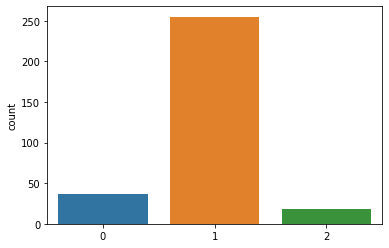

In [ ]:
seed_num=37

GBC_model = GradientBoostingClassifier(random_state=37
              ).fit(train_x, train_y)

preds = GBC_model.predict(test_x)
sns.countplot(x=preds);

# 5.Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('smartFactorySubmission.csv', index=False)

# THE END